In [1]:
import os
os.getcwd()



'/Users/carlahugod/Desktop/TorusNeuralMixtureModels/src/results'

In [2]:
os.chdir('../../')
os.getcwd()

'/Users/carlahugod/Desktop/TorusNeuralMixtureModels'

In [3]:
# Do NCE with two different init of theta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sys
sys.path.insert(0, '.')

from src.parameterEstimation.trainNCE import mixture_torch_loop
from src.parameterEstimation.NCE import TorusGraphs
from src.data.synthetic_data import sampleFromTorusGraph
from src.results.NMI import calc_NMI, calc_MI
from sklearn.metrics import confusion_matrix


N = 200 # samples
nodes = 3
K = 2 # number of models (or components)
phi1 = np.block([ 0, 0, 8*np.cos(np.pi), 8*np.sin(np.pi), 0, 0 ]) 
X1, datamodel = sampleFromTorusGraph(
        nodes = nodes,
        samples = N,
        phi = phi1,
        fitFCM = False,
        fitPAD = True,
        fitPAS = False,
        return_datamodel = True
    )
X1 = torch.from_numpy(X1).float().T
phi2 = np.block([ 0, 0, 8*np.sin(np.pi), 8*np.cos(np.pi), 0, 0 ]) 
X2, datamodel = sampleFromTorusGraph(
        nodes = nodes,
        samples = N,
        phi = phi2,
        fitFCM = False,
        fitPAD = True,
        fitPAS = False,
        return_datamodel = True
    )
X2 = torch.from_numpy(X2).float().T

X = torch.cat([X1,X2],dim=0)

N = 2*N
noise = torch.rand(N,nodes)*2*torch.tensor(np.pi) # Noise distribution, mellem 0 og 2*pi


model = TorusGraphs(nodes=X.shape[1],K=2,return_log_prop_data=True)
model,objective, log_prob_data = mixture_torch_loop(X,noise,model)
theta,c = model.theta,model.logc
print(log_prob_data.shape) # (K,N)
log_prob_data = torch.tensor(log_prob_data)


def compute_log_probs(self, log_prob_data, c):
    denominator = torch.sum(torch.exp(log_prob_data + self.logc.view(-1,1)), dim=0)
    z = torch.zeros(self.K, N)
    for k in range(self.K):
        for i in range(N):
            z[k, i] = torch.exp(log_prob_data[k, i] + c[k]) / denominator[i]
    return z


def classify_points(model, X, log_prob_data, c):
    log_probs = compute_log_probs(model, log_prob_data, c)
    print(log_probs.size())
    class_label = torch.argmax(log_probs, dim=0)
    return class_label


pred_labels = classify_points(model, X, log_prob_data, c).detach().numpy().reshape(-1,1)
true_labels = np.concatenate([np.ones(N//2),np.zeros(N//2)]).reshape(-1,1)

con_matrix = confusion_matrix(true_labels,pred_labels)


NCE training: 100%|██████████| 10000/10000 [00:18<00:00, 527.37it/s]

(2, 400)
torch.Size([2, 400])


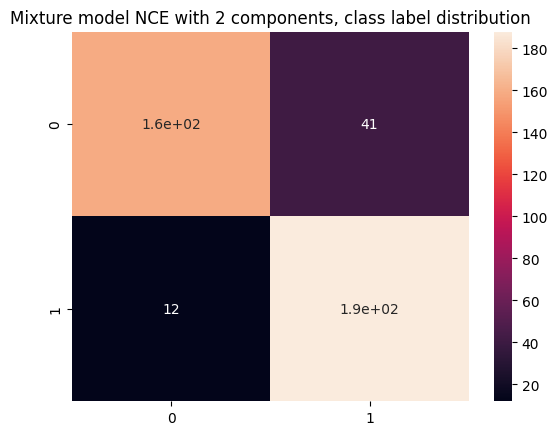

<Figure size 640x480 with 0 Axes>

In [4]:
sns.heatmap(con_matrix, annot=True)
plt.title("Mixture model NCE with 2 components, class label distribution")
plt.show()
plt.savefig("src/plots/mix_nce.png")



In [16]:
from src.results.NMI import calc_MI,calc_NMI

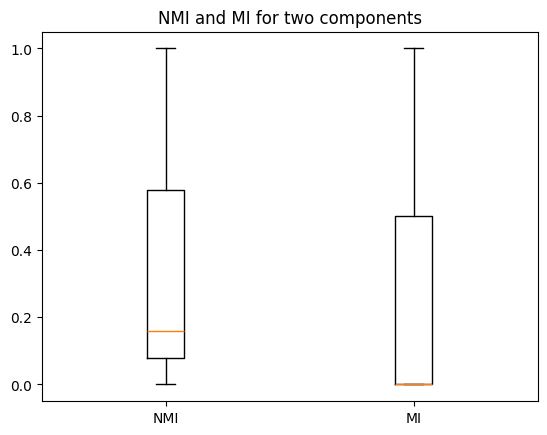

<Figure size 640x480 with 0 Axes>

In [22]:
# NMI: Normalized Mutual Information

MI = calc_MI(true_labels,pred_labels)
NMI = calc_NMI(true_labels,pred_labels)

# Plot boxplot of NMI and MI
plt.boxplot([[NMI,0,1],[MI,0,1]])
plt.xticks([1,2],["NMI","MI"])
plt.title("NMI and MI for two components")
plt.show()
plt.savefig("src/plots/NMI.png")


